In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms , models 
from torch.utils.data import DataLoader, random_split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
dataset_path = r"C:\Users\Hp\Desktop\train"

In [5]:
# Data Transformations
transform = transforms.Compose([
    transforms.Resize((512,512)),  # Resize to match EfficientNet input size
    transforms.ToTensor(),
])

In [6]:
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [7]:
# Get class names (folder names)
class_names = dataset.classes  # This returns a list of folder names
print(f"Classes: {class_names}")

Classes: ['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'german+shepherd', 'giant+panda', 'giraffe', 'grizzly+bear', 'hamster', 'hippopotamus', 'humpback+whale', 'killer+whale', 'leopard', 'lion', 'mole', 'mouse', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'raccoon', 'rat', 'seal', 'siamese+cat', 'skunk', 'spider+monkey', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


In [8]:
# Get the mapping of class indices to folder names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

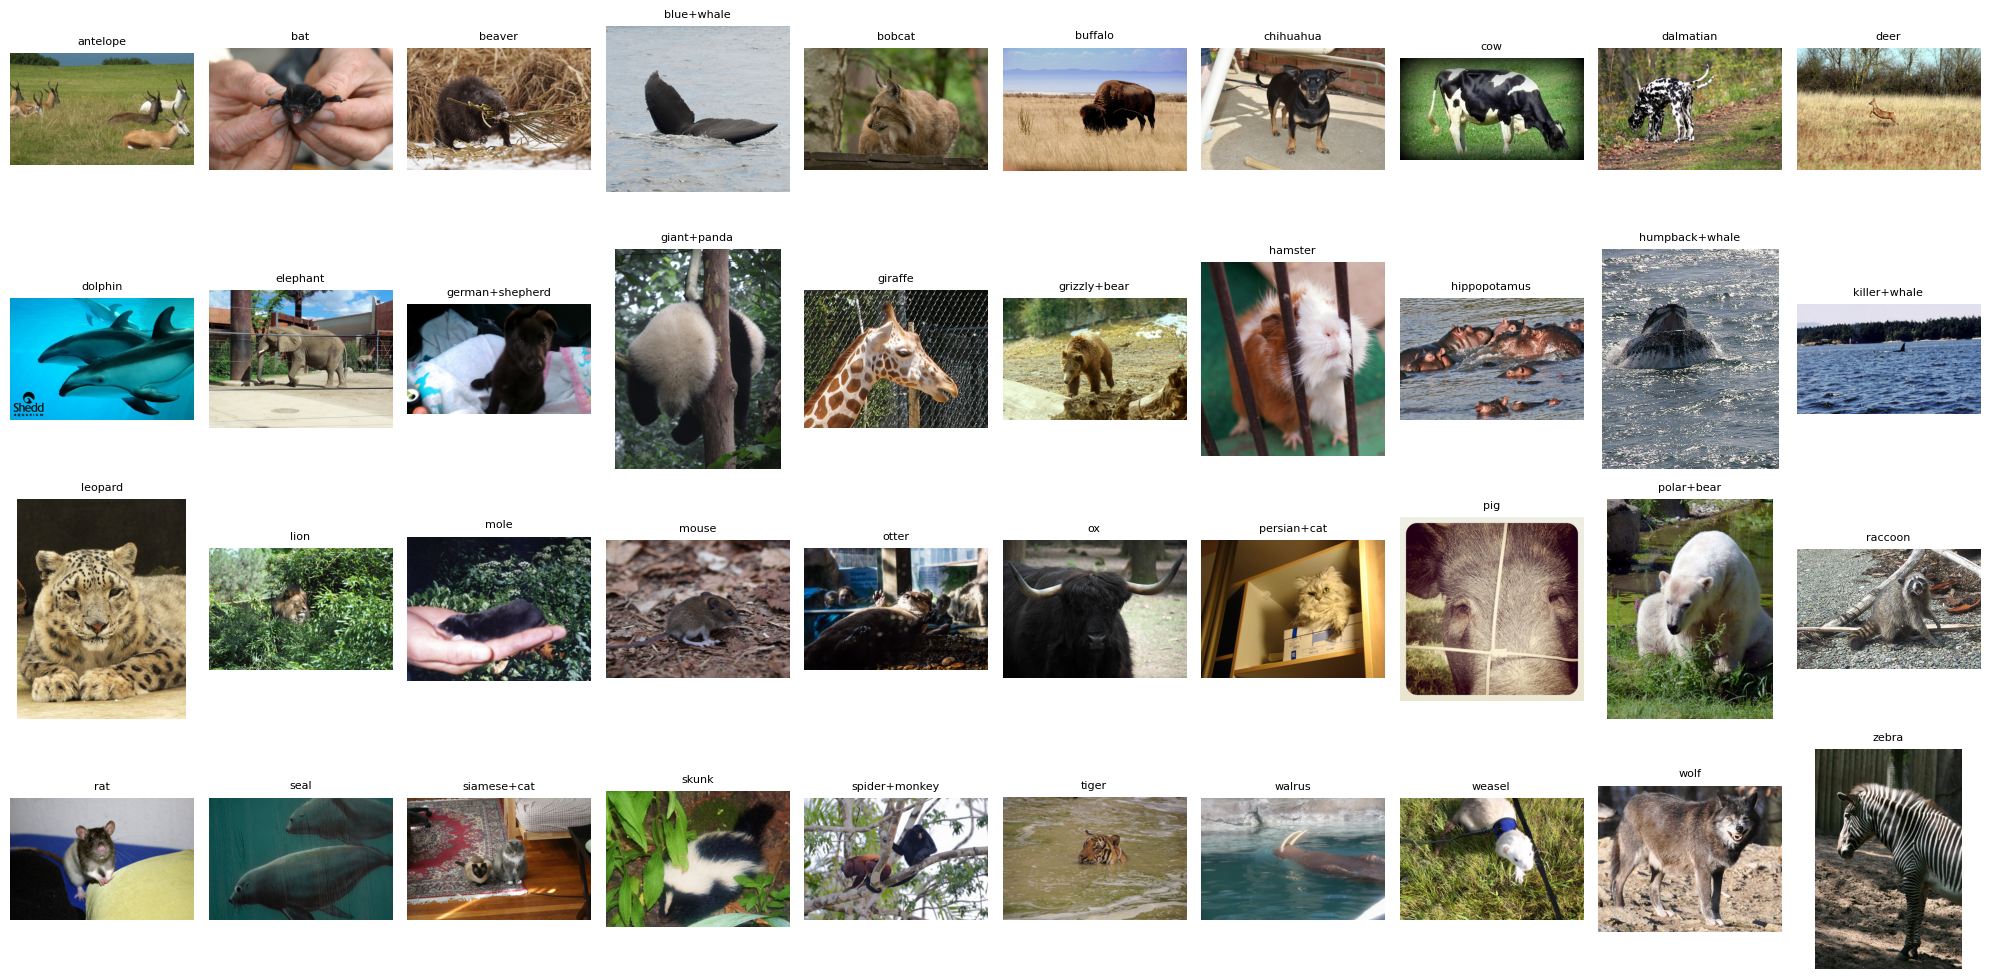

In [9]:
# Display the first image from each class
fig, axes = plt.subplots(4, 10, figsize=(20, 10))  # Adjust grid size for 50 classes
axes = axes.flatten()

for idx, class_name in enumerate(idx_to_class.values()):
    # Get the folder corresponding to the class
    class_folder = os.path.join(dataset_path, class_name)
    
    # Get the first image in the folder
    first_image_path = os.path.join(class_folder, os.listdir(class_folder)[0])
    
    # Load and display the image
    img = Image.open(first_image_path)
    axes[idx].imshow(img)
    axes[idx].set_title(class_name, fontsize=8)
    axes[idx].axis("off")

# Adjust layout and display
plt.tight_layout()
plt.show()

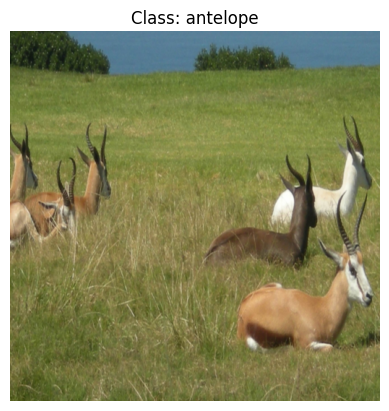

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Access the first image and its label from the dataset
first_image, first_label = dataset[0]  # dataset[0] returns a (Tensor, Label) pair

# Convert the tensor to a PIL image for visualization
first_image_pil = F.to_pil_image(first_image)

# Display the image
plt.imshow(first_image_pil)
plt.title(f"Class: {dataset.classes[first_label]}")  # Display the class name
plt.axis("off")
plt.show()


In [11]:
# Split the dataset into training and validation sets
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [12]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [13]:
# Load EfficientNet-B0 Pre-trained Model
model = models.efficientnet_v2_s(pretrained=True)

c:\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\Hp/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:22<00:00, 3.85MB/s]


In [14]:
# Define data augmentation for training data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [15]:
# Update train_loader and val_loader with respective transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=False)

In [16]:
# Modify the classifier for 50 classes
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 40)
)

model = model.to(device)

In [17]:
from lion_pytorch import Lion

In [18]:
# Loss Function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
# Updated training and evaluation function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    print("Training complete.")

In [20]:
# Train the Model
train_model(model, criterion, optimizer, scheduler, num_epochs=30)

Epoch 1/30
----------
Train Loss: 1.1072 Acc: 0.7033
Val Loss: 0.7448 Acc: 0.7744
Epoch 2/30
----------
Train Loss: 0.7311 Acc: 0.7748
Val Loss: 0.6979 Acc: 0.7842
Epoch 3/30
----------
Train Loss: 0.5520 Acc: 0.8251
Val Loss: 0.6617 Acc: 0.7947
Epoch 4/30
----------
Train Loss: 0.4299 Acc: 0.8600
Val Loss: 0.6932 Acc: 0.7961
Epoch 5/30
----------
Train Loss: 0.3699 Acc: 0.8817
Val Loss: 0.6828 Acc: 0.8024
Epoch 6/30
----------
Train Loss: 0.3097 Acc: 0.9008
Val Loss: 0.7870 Acc: 0.7842
Epoch 7/30
----------
Train Loss: 0.2849 Acc: 0.9091
Val Loss: 0.6955 Acc: 0.7961
Epoch 8/30
----------
Train Loss: 0.0995 Acc: 0.9702
Val Loss: 0.5612 Acc: 0.8492
Epoch 9/30
----------
Train Loss: 0.0308 Acc: 0.9912
Val Loss: 0.5665 Acc: 0.8547
Epoch 10/30
----------
Train Loss: 0.0195 Acc: 0.9947
Val Loss: 0.5750 Acc: 0.8603
Epoch 11/30
----------
Train Loss: 0.0141 Acc: 0.9965
Val Loss: 0.6098 Acc: 0.8485
Epoch 12/30
----------
Train Loss: 0.0100 Acc: 0.9975
Val Loss: 0.6273 Acc: 0.8610
Epoch 13/30
-

In [21]:
print(f"Classes: {class_names}")

Classes: ['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'german+shepherd', 'giant+panda', 'giraffe', 'grizzly+bear', 'hamster', 'hippopotamus', 'humpback+whale', 'killer+whale', 'leopard', 'lion', 'mole', 'mouse', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'raccoon', 'rat', 'seal', 'siamese+cat', 'skunk', 'spider+monkey', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


In [24]:
import csv

# Function to predict the class of an image
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Folder containing images to predict
prediction_folder = r'C:\Users\Hp\Desktop\predict_images'

# Check if the folder exists, if not create it
if not os.path.exists(prediction_folder):
    os.makedirs(prediction_folder)

# CSV file to save predictions
csv_file = 'predictions.csv'

# Transform for prediction (same as validation transform)
prediction_transform = data_transforms['val']

# List to store predictions
predictions = []

# Iterate over images in the folder
for image_name in os.listdir(prediction_folder):
    image_path = os.path.join(prediction_folder, image_name)
    predicted_class_idx = predict_image(image_path, model, prediction_transform, device)
    predicted_class_name = idx_to_class[predicted_class_idx]
    predictions.append([image_name, predicted_class_name])

# Write predictions to CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Class Predicted'])
    writer.writerows(predictions)

print(f"Predictions saved to {csv_file}")

Predictions saved to predictions.csv


In [25]:
# Folder containing images to predict
prediction_folder = r'C:\Users\Hp\Desktop\test'

# CSV file to save predictions
csv_file = os.path.join(prediction_folder, 'predictions.csv')

# List to store predictions
predictions = []

# Iterate over images in the folder
for image_name in os.listdir(prediction_folder):
    image_path = os.path.join(prediction_folder, image_name)
    predicted_class_idx = predict_image(image_path, model, prediction_transform, device)
    predicted_class_name = idx_to_class[predicted_class_idx]
    predictions.append([image_name, predicted_class_name])

# Write predictions to CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Class Predicted'])
    writer.writerows(predictions)

print(f"Predictions saved to {csv_file}")

Predictions saved to C:\Users\Hp\Desktop\test\predictions.csv
